In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pyspark

In [3]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

In [4]:
spark = SparkSession.builder.appName('cancer').getOrCreate()
lc = spark.read.csv('/content/drive/MyDrive/Bigdata Lanjut/FP/LungCancer.csv', header = True, inferSchema = True)
lc.printSchema()

root
 |-- GENDER: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SMOKING: integer (nullable = true)
 |-- YELLOW_FINGERS: integer (nullable = true)
 |-- ANXIETY: integer (nullable = true)
 |-- PEER_PRESSURE: integer (nullable = true)
 |-- CHRONIC DISEASE: integer (nullable = true)
 |-- FATIGUE : integer (nullable = true)
 |-- ALLERGY : integer (nullable = true)
 |-- WHEEZING: integer (nullable = true)
 |-- ALCOHOL CONSUMING: integer (nullable = true)
 |-- COUGHING: integer (nullable = true)
 |-- SHORTNESS OF BREATH: integer (nullable = true)
 |-- SWALLOWING DIFFICULTY: integer (nullable = true)
 |-- CHEST PAIN: integer (nullable = true)
 |-- LUNG_CANCER: integer (nullable = true)



In [5]:
# Daftar kolom yang akan diganti namanya
kolom_baru = {
    "GENDER": "Gender",
    "AGE": "Age",
    "SMOKING": "Smoking",
    "YELLOW_FINGERS": "Yellow_fingers",
    "ANXIETY": "Anxiety",
    "PEER_PRESSURE": "Peer_pressure",
    "CHRONIC DISEASE": "Chronik_disease",
    "FATIGUE ": "Fatigue",
    "ALLERGY ": "Allergy",
    "WHEEZING": "Weezing",
    "ALCOHOL CONSUMING":"Alcohol_consuming",
    "COUGHING": "Coughing",
    "SHORTNESS OF BREATH": "Shortness_of_breath",
    "SWALLOWING DIFFICULTY": "Swallowing_difficulty",
    "CHEST PAIN": "Chest_paint",
}

# Melakukan penggantian nama kolom
for kolom_lama, kolom_baru in kolom_baru.items():
    lc = lc.withColumnRenamed(kolom_lama, kolom_baru)

# Tampilkan DataFrame setelah perubahan nama kolom
lc.show()

+------+---+-------+--------------+-------+-------------+---------------+-------+-------+-------+-----------------+--------+-------------------+---------------------+-----------+-----------+
|Gender|Age|Smoking|Yellow_fingers|Anxiety|Peer_pressure|Chronik_disease|Fatigue|Allergy|Weezing|Alcohol_consuming|Coughing|Shortness_of_breath|Swallowing_difficulty|Chest_paint|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+-------+-----------------+--------+-------------------+---------------------+-----------+-----------+
|     0| 69|      1|             2|      2|            1|              1|      2|      1|      2|                2|       2|                  2|                    2|          2|          1|
|     0| 74|      2|             1|      1|            1|              2|      2|      2|      1|                1|       1|                  2|                    2|          2|          1|
|     1| 59|      1|             1|      1|  

In [6]:
lcdisp = lc.limit(10).toPandas().transpose()
lcdisp.head(16)

,0,1,2,3,4,5,6,7,8,9
Gender,0,0,1,0,1,1,0,1,1,0
Age,69,74,59,63,63,75,52,51,68,53
Smoking,1,2,1,2,1,1,2,2,2,2
Yellow_fingers,2,1,1,2,2,2,1,2,1,2
Anxiety,2,1,1,2,1,1,1,2,2,2
Peer_pressure,1,1,2,1,1,1,1,2,1,2
Chronik_disease,1,2,1,1,1,2,1,1,1,2
Fatigue,2,2,2,1,1,2,2,2,2,1
Allergy,1,2,1,1,1,2,1,2,1,2
Weezing,2,1,2,1,2,2,2,1,1,1


In [7]:
numeric_features = [t[0] for t in lc.dtypes if t[1]]
# yang diambil hanya kolom yang memiliki fitur numerik
numeric_summary = lc.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+---------------------+------------------+-------------------+
|summary|Gender            |Age               |Smoking           |Yellow_fingers    |Anxiety           |Peer_pressure      |Chronik_disease   |Fatigue           |Allergy           |Weezing           |Alcohol_consuming |Coughing           |Shortness_of_breath|Swallowing_difficulty|Chest_paint       |LUNG_CANCER        |
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+---------------------+------------------+-------------------+
|count  |55394             |55394    

In [8]:
missing_values = lc.select([col(c).alias(c) for c in lc.columns]).na.fill(0).agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in lc.columns])

# Menampilkan hasil
print("Jumlah nilai-nilai yang hilang pada setiap kolom:")
missing_values.show(truncate=False)

Jumlah nilai-nilai yang hilang pada setiap kolom:
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+-------+-----------------+--------+-------------------+---------------------+-----------+-----------+
|Gender|Age|Smoking|Yellow_fingers|Anxiety|Peer_pressure|Chronik_disease|Fatigue|Allergy|Weezing|Alcohol_consuming|Coughing|Shortness_of_breath|Swallowing_difficulty|Chest_paint|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+-------+-----------------+--------+-------------------+---------------------+-----------+-----------+
|0     |0  |0      |0             |0      |0            |0              |0      |0      |0      |0                |0       |0                  |0                    |0          |0          |
+------+---+-------+--------------+-------+-------------+---------------+-------+-------+-------+-----------------+--------+-------------------+---------------------+-----------+--------

In [9]:
lungcancer_sum = lc.groupBy('LUNG_CANCER').count()

# Menampilkan hasil
print("Jumlah kemunculan setiap nilai pada kolom 'LUNG_CANCER':")
lungcancer_sum.show()

Jumlah kemunculan setiap nilai pada kolom 'LUNG_CANCER':
+-----------+-----+
|LUNG_CANCER|count|
+-----------+-----+
|          1|27913|
|          2|27481|
+-----------+-----+



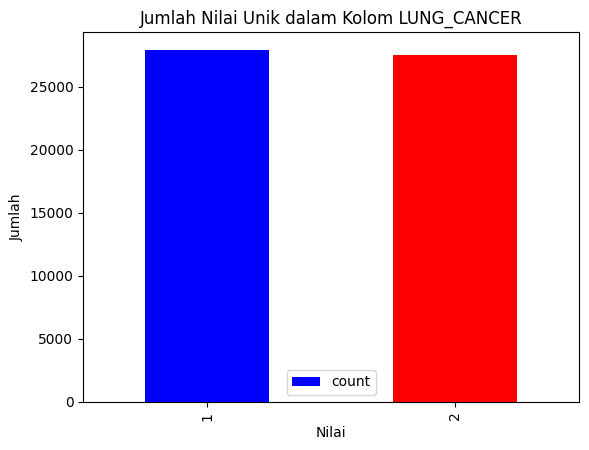

In [10]:
lungcancer_counts_pd = lungcancer_sum.toPandas()

# Plot bar chart
lungcancer_counts_pd.plot(kind='bar', x='LUNG_CANCER', y='count', color=['blue', 'red'])
plt.title('Jumlah Nilai Unik dalam Kolom LUNG_CANCER')
plt.xlabel('Nilai')
plt.ylabel('Jumlah')
plt.show()

In [11]:
lcprepose = lc.drop('Gender', 'Fatigue', 'Weezing', 'Swallowing_difficulty')

In [12]:
# Daftar kolom yang ingin diubah nilai
columns_to_change = ["Smoking", "Yellow_fingers", "Anxiety", "Peer_pressure", "Chronik_disease", "Allergy", "Alcohol_consuming", "Coughing", "Shortness_of_breath", "Chest_paint", "LUNG_CANCER"]

# Menggunakan when dan otherwise untuk mengganti nilai
for column in columns_to_change:
    lcprepose = lcprepose.withColumn(column, when(lcprepose[column] == 2, 1).when(lcprepose[column] == 1, 0).otherwise(lcprepose[column]))

# Menampilkan hasil DataFrame setelah perubahan nilai
lcprepose.show()

+---+-------+--------------+-------+-------------+---------------+-------+-----------------+--------+-------------------+-----------+-----------+
|Age|Smoking|Yellow_fingers|Anxiety|Peer_pressure|Chronik_disease|Allergy|Alcohol_consuming|Coughing|Shortness_of_breath|Chest_paint|LUNG_CANCER|
+---+-------+--------------+-------+-------------+---------------+-------+-----------------+--------+-------------------+-----------+-----------+
| 69|      0|             1|      1|            0|              0|      0|                1|       1|                  1|          1|          0|
| 74|      1|             0|      0|            0|              1|      1|                0|       0|                  1|          1|          0|
| 59|      0|             0|      0|            1|              0|      0|                0|       1|                  1|          1|          1|
| 63|      1|             1|      1|            0|              0|      0|                1|       0|                  0|   

In [13]:
lcdisp1 = lcprepose.limit(10).toPandas().transpose()
lcdisp1.head(16)

,0,1,2,3,4,5,6,7,8,9
Age,69,74,59,63,63,75,52,51,68,53
Smoking,0,1,0,1,0,0,1,1,1,1
Yellow_fingers,1,0,0,1,1,1,0,1,0,1
Anxiety,1,0,0,1,0,0,0,1,1,1
Peer_pressure,0,0,1,0,0,0,0,1,0,1
Chronik_disease,0,1,0,0,0,1,0,0,0,1
Allergy,0,1,0,0,0,1,0,1,0,1
Alcohol_consuming,1,0,0,1,0,0,1,0,0,1
Coughing,1,0,1,0,1,1,1,0,0,0
Shortness_of_breath,1,1,1,0,1,1,1,1,0,0


In [14]:
# menampilkan summary

numeric_features = [t[0] for t in lcprepose.dtypes if t[1]]
# yang diambil hanya kolom yang memiliki fitur numerik
numeric_summary = lcprepose.select(numeric_features).summary()
numeric_summary.show(truncate=False)

+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|summary|Age               |Smoking           |Yellow_fingers     |Anxiety           |Peer_pressure     |Chronik_disease   |Allergy           |Alcohol_consuming |Coughing          |Shortness_of_breath|Chest_paint       |LUNG_CANCER        |
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+
|count  |55394             |55394             |55394              |55394             |55394             |55394             |55394             |55394             |55394             |55394              |55394             |55394              |
|mean   |44.137614182041375|0.499530

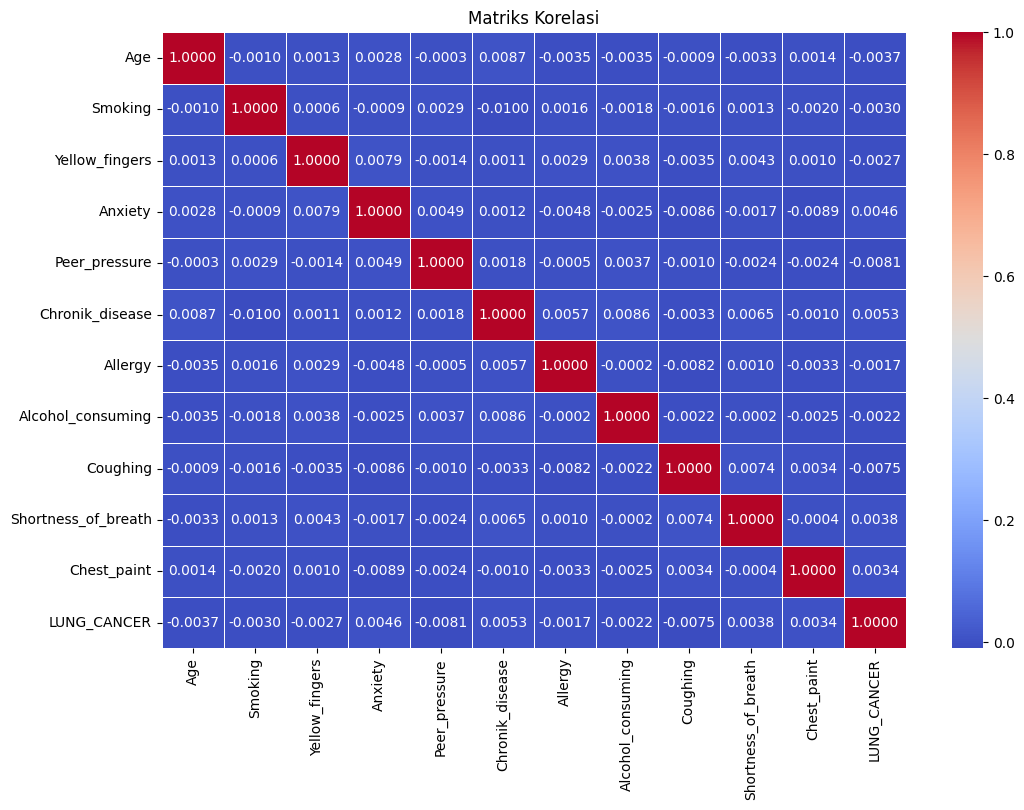

In [15]:
integer_columns = [col_name for col_name, col_type in lcprepose.dtypes if col_type == 'int']


vector_assembler = VectorAssembler(inputCols=integer_columns, outputCol="features")
lcprepose_assembled = vector_assembler.transform(lcprepose).select("features")


matrix = Correlation.corr(lcprepose_assembled, "features").head()
correlation_matrix = matrix[0].toArray()


column_names = lcprepose_assembled.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]


plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.5,
            xticklabels=[col["name"] for col in column_names], yticklabels=[col["name"] for col in column_names])
plt.title("Matriks Korelasi")
plt.show()

# Logistic Regresion

In [16]:
# Nama kolom-kolom
feature_columns = [col for col in lcprepose.columns if col != 'LUNG_CANCER']

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
lcreg = assembler.transform(lcprepose).select('features', 'LUNG_CANCER')

# Tampilkan hasil
lcreg.show(truncate=False)

+----------------------------------------------+-----------+
|features                                      |LUNG_CANCER|
+----------------------------------------------+-----------+
|[69.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0]|0          |
|(11,[0,1,5,6,9,10],[74.0,1.0,1.0,1.0,1.0,1.0])|0          |
|(11,[0,4,8,9,10],[59.0,1.0,1.0,1.0,1.0])      |1          |
|(11,[0,1,2,3,7,10],[63.0,1.0,1.0,1.0,1.0,1.0])|1          |
|(11,[0,2,8,9],[63.0,1.0,1.0,1.0])             |1          |
|(11,[0,2,5,6,8,9],[75.0,1.0,1.0,1.0,1.0,1.0]) |0          |
|(11,[0,1,7,8,9,10],[52.0,1.0,1.0,1.0,1.0,1.0])|0          |
|[51.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0]|0          |
|(11,[0,1,3],[68.0,1.0,1.0])                   |1          |
|[53.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0]|0          |
|[61.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0]|0          |
|[72.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0]|0          |
|(11,[0,1,9],[60.0,1.0,1.0])                   |1          |
|[58.0,1.0,0.0,0.0,0.0,0

In [17]:
train, test = lcreg.randomSplit([0.8, 0.2], seed = 5)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 44232
Test Dataset Count: 11162


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'LUNG_CANCER', maxIter=3)
lrModel = lr.fit(train)

predictions = lrModel.transform(test)

# Inisialisasi evaluator akurasi
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi akurasi
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Test Accuracy: {accuracy:.2%}')

# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# Evaluasi F1-score
f1_score = evaluator_f1.evaluate(predictions)
print(f'Test F1-Score: {f1_score:.2%}')

# Filter prediksi yang salah
wrong_predictions = predictions.filter(col('LUNG_CANCER') != col('prediction'))

# Tampilkan hasil
wrong_predictions.select('features', 'LUNG_CANCER', 'rawPrediction', 'prediction', 'probability').show(10)

# Hitung jumlah prediksi yang salah
count_wrong_predictions = wrong_predictions.count()
print(f'Jumlah prediksi yang salah: {count_wrong_predictions}')

Test Accuracy: 50.58%
Test F1-Score: 47.67%
+--------------------+-----------+--------------------+----------+--------------------+
|            features|LUNG_CANCER|       rawPrediction|prediction|         probability|
+--------------------+-----------+--------------------+----------+--------------------+
|     (11,[0],[47.0])|          1|[0.00323946592560...|       0.0|[0.50080986577316...|
|     (11,[0],[65.0])|          1|[0.01807629476860...|       0.0|[0.50451895064464...|
|(11,[0,1],[21.0,1...|          0|[-0.0147047248045...|       1.0|[0.49632388503883...|
|(11,[0,1],[21.0,1...|          0|[-0.0147047248045...|       1.0|[0.49632388503883...|
|(11,[0,1],[33.0,1...|          0|[-0.0048135055758...|       1.0|[0.49879662592953...|
|(11,[0,1],[33.0,1...|          0|[-0.0048135055758...|       1.0|[0.49879662592953...|
|(11,[0,1],[36.0,1...|          0|[-0.0023407007686...|       1.0|[0.49941482507500...|
|(11,[0,1],[39.0,1...|          1|[1.32104038497261...|       0.0|[0.5000330

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


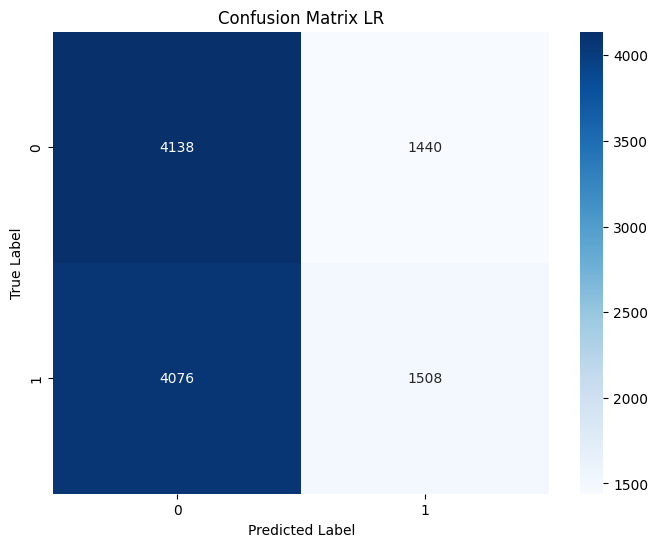

In [19]:
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_and_labels = predictions.select('prediction', 'LUNG_CANCER').rdd.map(lambda row: (float(row['prediction']), float(row['LUNG_CANCER'])))

# Inisialisasi MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_labels)

# Ambil confusion matrix sebagai array
confusion_matrix = metrics.confusionMatrix().toArray()

# Konversi confusion matrix ke tipe data integer
confusion_matrix = confusion_matrix.astype(int)

# Tampilkan confusion matrix menggunakan seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Decision Tree Classifier

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

feature_columns_dua = [col for col in lcprepose.columns if col != 'LUNG_CANCER']

# Menggunakan VectorAssembler untuk menggabungkan fitur-fitur menjadi satu kolom vektor
assembler2 = VectorAssembler(inputCols=feature_columns_dua, outputCol='features')

# Inisialisasi DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='LUNG_CANCER', featuresCol='features')

# Membuat pipeline dengan assembler dan DecisionTreeClassifier
pipeline = Pipeline(stages=[assembler2, dt])

# Membagi data menjadi train dan test
train2, test2 = lcprepose.randomSplit([0.8, 0.2], seed=5)

# Melatih model menggunakan train data
model = pipeline.fit(train2)

# Melakukan prediksi pada test data
predictionsDTC = model.transform(test2)

# Evaluasi model menggunakan MulticlassClassificationEvaluator
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='accuracy'
)

# Mengukur akurasi
accuracy = evaluator_accuracy.evaluate(predictionsDTC)
print(f'Test Accuracy: {accuracy:.2%}')

# Evaluasi model menggunakan F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# Mengukur F1-Score
f1_score = evaluator_f1.evaluate(predictionsDTC)
print(f'Test F1-Score: {f1_score:.2%}')

# Menampilkan hasil prediksi
predictionsDTC.select('AGE', 'LUNG_CANCER', 'rawPrediction', 'prediction', 'probability').show(10)


Test Accuracy: 49.97%
Test F1-Score: 49.98%
+---+-----------+-------------+----------+--------------------+
|AGE|LUNG_CANCER|rawPrediction|prediction|         probability|
+---+-----------+-------------+----------+--------------------+
| 18|          1|[187.0,152.0]|       0.0|[0.55162241887905...|
| 18|          1|  [72.0,61.0]|       0.0|[0.54135338345864...|
| 18|          1|[187.0,152.0]|       0.0|[0.55162241887905...|
| 18|          0|  [83.0,69.0]|       0.0|[0.54605263157894...|
| 18|          1|[187.0,152.0]|       0.0|[0.55162241887905...|
| 18|          1|  [76.0,93.0]|       1.0|[0.44970414201183...|
| 18|          1|  [72.0,61.0]|       0.0|[0.54135338345864...|
| 18|          0|  [66.0,75.0]|       1.0|[0.46808510638297...|
| 18|          0|  [81.0,72.0]|       0.0|[0.52941176470588...|
| 18|          1|  [81.0,72.0]|       0.0|[0.52941176470588...|
+---+-----------+-------------+----------+--------------------+
only showing top 10 rows



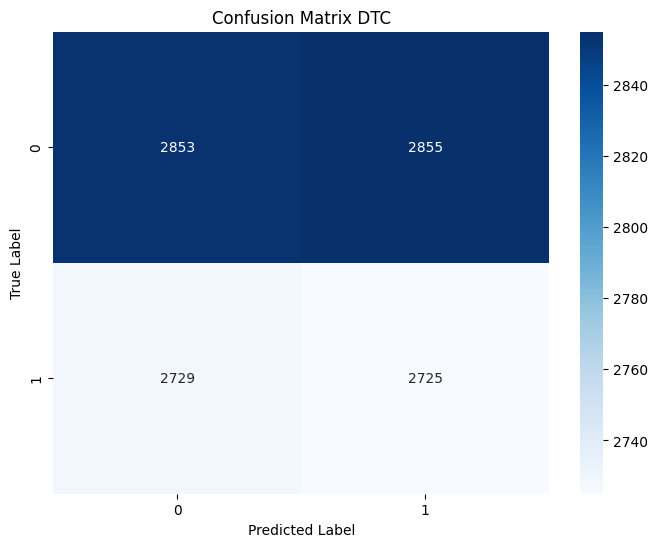

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Cast 'LUNG_CANCER' column to DoubleType
predictionsDTC = predictionsDTC.withColumn('LUNG_CANCER', col('LUNG_CANCER').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsDTC = predictionsDTC.select('prediction', 'LUNG_CANCER').rdd

# Inisialisasi MulticlassMetrics
metricsDTC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixDTC = metricsDTC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_DTC = pd.DataFrame(confusion_matrixDTC, columns=[str(i) for i in range(confusion_matrixDTC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_DTC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix DTC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Random Forest Classifier

In [22]:
from pyspark.ml.classification import RandomForestClassifier
# Inisialisasi model Random Forest
rf = RandomForestClassifier(labelCol="LUNG_CANCER", featuresCol="features", numTrees=10)

# Pipeline
pipeline_rf = Pipeline(stages=[assembler2, rf])

# Train model
model_rf = pipeline_rf.fit(train2)

# Make predictions
predictionRFC = model_rf.transform(test2)

# Evaluate accuracy
evaluator_accuracy_rf = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluate F1-Score
evaluator_f1_rf = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_rf = evaluator_accuracy_rf.evaluate(predictionRFC)
print(f'Test Accuracy: {accuracy_rf:.2%}')

# F1-Score
f1_score_rf = evaluator_f1_rf.evaluate(predictionRFC)
print(f'Test F1-Score: {f1_score_rf:.2%}')

predictionRFC.select('AGE', 'LUNG_CANCER', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 50.61%
Test F1-Score: 49.88%
+---+-----------+--------------------+----------+--------------------+
|AGE|LUNG_CANCER|       rawPrediction|prediction|         probability|
+---+-----------+--------------------+----------+--------------------+
| 18|          1|[5.18542735594295...|       0.0|[0.51854273559429...|
| 18|          1|[5.04101292303670...|       0.0|[0.50410129230367...|
| 18|          1|[5.30108370198968...|       0.0|[0.53010837019896...|
| 18|          0|[5.19714633806939...|       0.0|[0.51971463380693...|
| 18|          1|[5.17132485970806...|       0.0|[0.51713248597080...|
| 18|          1|[5.19716480018053...|       0.0|[0.51971648001805...|
| 18|          1|[5.21904087046901...|       0.0|[0.52190408704690...|
| 18|          0|[5.12835351544644...|       0.0|[0.51283535154464...|
| 18|          0|[5.17361134516119...|       0.0|[0.51736113451611...|
| 18|          1|[5.17361134516119...|       0.0|[0.51736113451611...|
+---+-----------+----------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


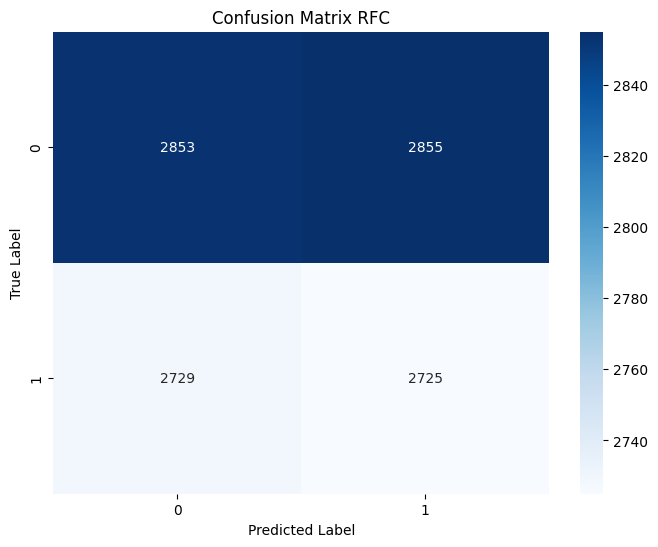

In [23]:
# Cast 'LUNG_CANCER' column to DoubleType
predictionsRFC = predictionRFC.withColumn('LUNG_CANCER', col('LUNG_CANCER').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsRFC = predictionsRFC.select('prediction', 'LUNG_CANCER').rdd

# Inisialisasi MulticlassMetrics
metricsRFC = MulticlassMetrics(predictionAndLabelsDTC)

# Mendapatkan matriks konfusi
confusion_matrixRFC = metricsRFC.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_RFC = pd.DataFrame(confusion_matrixRFC, columns=[str(i) for i in range(confusion_matrixRFC.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_RFC, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix RFC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# Gradient-Boosted Trees

In [24]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Inisialisasi GBTClassifier
gbt = GBTClassifier(labelCol="LUNG_CANCER", featuresCol="features", maxIter=10)

# Pipeline
pipeline_gbt = Pipeline(stages=[assembler, gbt])

# Train model
model_gbt = pipeline_gbt.fit(train2)

# Melakukan prediksi pada test data
prediction_gbt = model_gbt.transform(test2)

# Evaluasi model menggunakan MulticlassClassificationEvaluator
evaluator_accuracy_gbt = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='accuracy'
)

# Evaluasi F1-Score
evaluator_f1_gbt = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# Accuracy
accuracy_gbt = evaluator_accuracy_gbt.evaluate(prediction_gbt)
print(f'Test Accuracy: {accuracy_gbt:.2%}')

# F1-Score
f1_score_gbt = evaluator_f1_gbt.evaluate(prediction_gbt)
print(f'Test F1-Score: {f1_score_gbt:.2%}')

# Menampilkan hasil prediksi
prediction_gbt.select('AGE', 'LUNG_CANCER', 'rawPrediction', 'prediction', 'probability').show(10)

Test Accuracy: 50.08%
Test F1-Score: 50.04%
+---+-----------+--------------------+----------+--------------------+
|AGE|LUNG_CANCER|       rawPrediction|prediction|         probability|
+---+-----------+--------------------+----------+--------------------+
| 18|          1|[0.23500102589914...|       0.0|[0.61538424202420...|
| 18|          1|[0.13889656185243...|       0.0|[0.56900509598119...|
| 18|          1|[0.19516946607669...|       0.0|[0.59636428764939...|
| 18|          0|[0.10061386319417...|       0.0|[0.55013786131101...|
| 18|          1|[0.16955226271357...|       0.0|[0.58397298506975...|
| 18|          1|[-0.0937472569772...|       1.0|[0.45326320754307...|
| 18|          1|[0.10627859985789...|       0.0|[0.55294012779347...|
| 18|          0|[-0.0658751576565...|       1.0|[0.46710998322190...|
| 18|          0|[0.10245106238144...|       0.0|[0.55104705566253...|
| 18|          1|[0.10245106238144...|       0.0|[0.55104705566253...|
+---+-----------+----------------

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


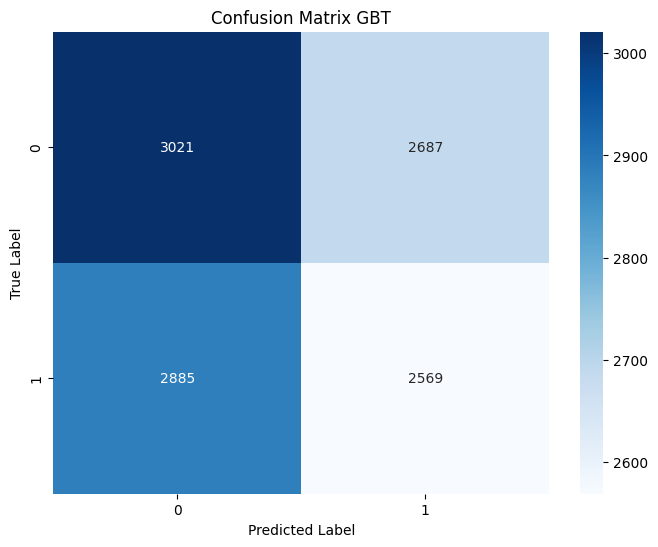

In [25]:
# Cast 'LUNG_CANCER' column to DoubleType
predictionsGBT = prediction_gbt.withColumn('LUNG_CANCER', col('LUNG_CANCER').cast('double'))

# Mengambil kolom label dan prediksi sebagai RDD untuk MulticlassMetrics
predictionAndLabelsGBT = predictionsGBT.select('prediction', 'LUNG_CANCER').rdd

# Inisialisasi MulticlassMetrics
metricsGBT = MulticlassMetrics(predictionAndLabelsGBT)

# Mendapatkan matriks konfusi
confusion_matrixGBT = metricsGBT.confusionMatrix().toArray()

# Konversi matriks konfusi menjadi DataFrame
confusion_matrix_GBT = pd.DataFrame(confusion_matrixGBT, columns=[str(i) for i in range(confusion_matrixGBT.shape[1])])

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_GBT, annot=True, fmt="g", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix GBT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.show()


## Hypertune DTC dan GBT

In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4, 12, 24])  # Variasi kedalaman maksimum pohon
             .addGrid(dt.impurity, ['gini', 'entropy'])  # Variasi jenis impurity
             .addGrid(dt.minInstancesPerNode, [2, 4, 6, 8])  # Variasi minimum instances per node
             #.addGrid(dt.maxBins, [5, 10, 15])  # Variasi jumlah bins maksimum
             .build())

# Inisialisasi evaluator F1-score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# CrossValidator
cvdt = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator_f1, numFolds=5)

# Fit the model
cvModeldt = cvdt.fit(train2)

# Make predictions on test data
predictionsDTC_tuned = cvModeldt.transform(test2)

# Evaluate the model
f1_score_tuned = evaluator_f1.evaluate(predictionsDTC_tuned)
print(f'Tuned Test F1-Score: {f1_score_tuned:.2%}')

# Best hyperparameters
best_params = cvModeldt.bestModel.stages[-1].extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Test F1-Score: 50.39%
Best Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: LUNG_CANCER
leafCol: 
maxBins: 32
maxDepth: 24
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 4
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -8505058873202339689


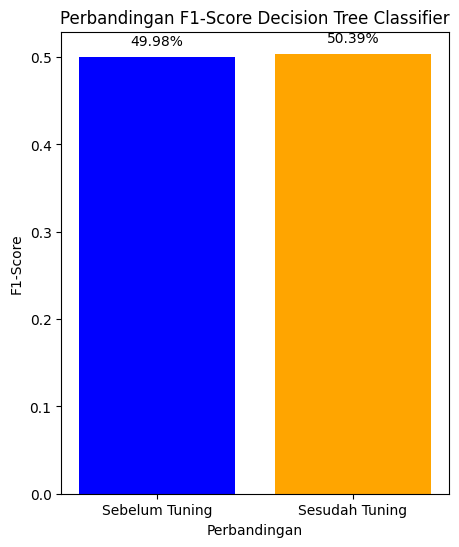

In [41]:
f1_score_before_tuning_DTC = [f1_score]  # Gantilah dengan nilai F1-Score sebelum tuning untuk setiap model

# F1-Score setelah tuning
f1_score_after_tuning_DTC = [f1_score_tuned]  # Gantilah dengan nilai F1-Score setelah tuning untuk setiap model

# Nama model atau metode
model_name_DTC = ['Sebelum Tuning', 'Sesudah Tuning']  # Gantilah dengan nama model atau metode yang sesuai

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_DTC, [max(f1_score_before_tuning_DTC), max(f1_score_after_tuning_DTC)], color=['blue', 'orange'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Decision Tree Classifier')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_before_tuning_DTC), max(f1_score_after_tuning_DTC)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

In [35]:
paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [4, 12, 24])  # Variasi kedalaman maksimum pohon
                 #.addGrid(gbt.maxBins, [2, 4, 6, 8])  # Variasi jumlah bins maksimum
                 .addGrid(gbt.minInstancesPerNode, [2, 4, 6, 8])
                 #.addGrid(gbt.stepSize, [0.1, 0.05, 0.01])  # Variasi step size
                 .build())

# Inisialisasi evaluator F1-score
evaluator_f1_gbt = MulticlassClassificationEvaluator(
    labelCol='LUNG_CANCER',
    predictionCol='prediction',
    metricName='f1'
)

# CrossValidator
cv_gbt = CrossValidator(estimator=pipeline_gbt, estimatorParamMaps=paramGrid_gbt, evaluator=evaluator_f1_gbt, numFolds=5)

# Train model
cvModel_gbt = cv_gbt.fit(train2)

# Make predictions on test data
prediction_gbt_tuned = cvModel_gbt.transform(test2)

# Evaluate the model
f1_score_gbt_tuned = evaluator_f1_gbt.evaluate(prediction_gbt_tuned)
print(f'Tuned Test F1-Score: {f1_score_gbt_tuned:.2%}')

# Best hyperparameters
best_params_gbt = cvModel_gbt.bestModel.stages[-1].extractParamMap()
print("Best Hyperparameters:")
for param, value in best_params_gbt.items():
    print(f"{param.name}: {value}")

Tuned Test F1-Score: 51.06%
Best Hyperparameters:
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: all
featuresCol: features
impurity: variance
labelCol: LUNG_CANCER
leafCol: 
lossType: logistic
maxBins: 32
maxDepth: 24
maxIter: 10
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 4
minWeightFractionPerNode: 0.0
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -5063908242000342527
stepSize: 0.1
subsamplingRate: 1.0
validationTol: 0.01


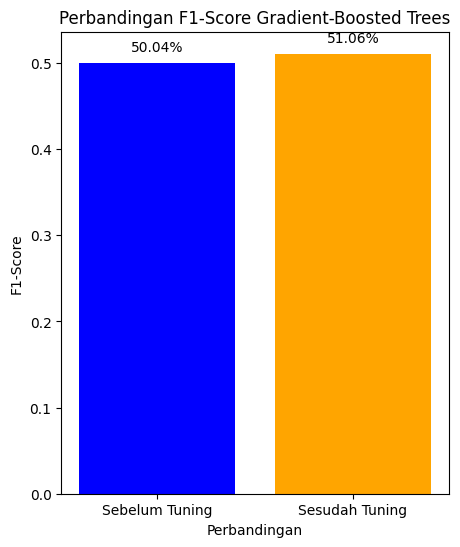

In [61]:
f1_score_before_tuning_GBT = [f1_score_gbt]  # Gantilah dengan nilai F1-Score sebelum tuning untuk setiap model

# F1-Score setelah tuning
f1_score_after_tuning_GBT = [f1_score_gbt_tuned]  # Gantilah dengan nilai F1-Score setelah tuning untuk setiap model

# Nama model atau metode
model_name_GBT = ['Sebelum Tuning', 'Sesudah Tuning']  # Gantilah dengan nama model atau metode yang sesuai

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_GBT, [max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)], color=['blue', 'orange'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score Gradient-Boosted Trees')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_before_tuning_GBT), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

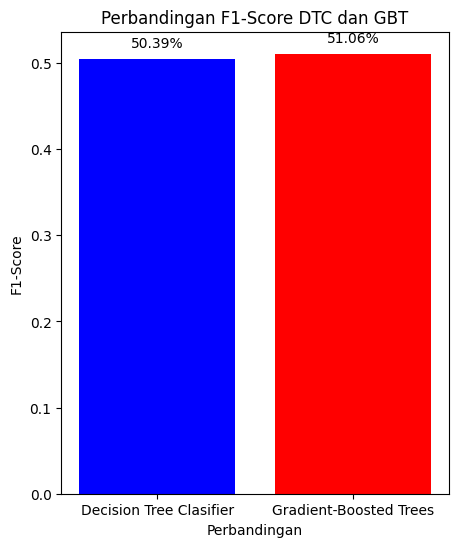

In [59]:
# Nama model atau metode
model_name_compare = ['Decision Tree Clasifier', 'Gradient-Boosted Trees']  # Gantilah dengan nama model atau metode yang sesuai

# Plotting
plt.figure(figsize=(5, 6))
plt.bar(model_name_compare, [max(f1_score_after_tuning_DTC), max(f1_score_after_tuning_GBT)], color=['blue', 'red'])

# Menambahkan label dan judul
plt.xlabel('Perbandingan')
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score DTC dan GBT')

# Menampilkan nilai F1-Score di atas batang
for i, value in enumerate([max(f1_score_after_tuning_DTC), max(f1_score_after_tuning_GBT)]):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

# Menampilkan plot
plt.show()

# Model Terbaik

Gradient-Boosted Trees

In [44]:
best_model = cvModel_gbt.bestModel
# Ambil stage terakhir dari model (GBTClassifier)
best_gbt_model = best_model.stages[-1]
# Dapatkan model trees dari GBTClassifier
trees = best_gbt_model.trees
# Tampilkan model trees
for idx, tree in enumerate(trees):
    print(f"Tree {idx + 1}:\n{tree.toDebugString}\n{'='*40}")

Tree 1:
DecisionTreeRegressionModel: uid=dtr_ef100664505c, depth=22, numNodes=15479, numFeatures=11
  If (feature 0 <= 20.5)
   If (feature 7 <= 0.5)
    If (feature 4 <= 0.5)
     If (feature 10 <= 0.5)
      If (feature 1 <= 0.5)
       If (feature 8 <= 0.5)
        If (feature 2 <= 0.5)
         If (feature 3 <= 0.5)
          If (feature 5 <= 0.5)
           If (feature 9 <= 0.5)
            Predict: -1.0
           Else (feature 9 > 0.5)
            Predict: -0.6666666666666666
          Else (feature 5 > 0.5)
           If (feature 9 <= 0.5)
            Predict: -0.3333333333333333
           Else (feature 9 > 0.5)
            Predict: -0.7142857142857143
         Else (feature 3 > 0.5)
          If (feature 9 <= 0.5)
           Predict: -0.6666666666666666
          Else (feature 9 > 0.5)
           If (feature 5 <= 0.5)
            Predict: 0.2
           Else (feature 5 > 0.5)
            Predict: 0.0
        Else (feature 2 > 0.5)
         If (feature 9 <= 0.5)
          If (

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [55]:
from pyspark.sql import Row

# Buat data uji (ganti nilainya sesuai keinginan Anda)
test_data = Row(
    Age=67,
    Smoking=1,
    Yellow_fingers=0,
    Anxiety=1,
    Peer_pressure=0,
    Chronik_disease=1,
    Allergy=0,
    Alcohol_consuming=1,
    Coughing=1,
    Shortness_of_breath=1,
    Chest_paint=1
)

# Konversi data menjadi DataFrame
test_df = spark.createDataFrame([test_data])

# Gunakan model GBT yang telah di-tune untuk membuat prediksi
predictions = cvModel_gbt.transform(test_df)

# Tampilkan hasil prediksi
result = predictions.select("prediction").collect()[0]["prediction"]

# Interpretasikan hasil prediksi
if result == 1.0:
    print("Prediksi: Terkena LUNG CANCER")
else:
    print("Prediksi: Tidak Terkena LUNG CANCER")

Prediksi: Terkena LUNG CANCER


In [58]:
test_data_2 = Row(
    Age=20,
    Smoking=0,
    Yellow_fingers=0,
    Anxiety=1,
    Peer_pressure=0,
    Chronik_disease=0,
    Allergy=0,
    Alcohol_consuming=0,
    Coughing=1,
    Shortness_of_breath=0,
    Chest_paint=0
)

# Konversi data menjadi DataFrame
test_df_2 = spark.createDataFrame([test_data_2])

# Gunakan model GBT yang telah di-tune untuk membuat prediksi
predictions_2 = cvModel_gbt.transform(test_df_2)

# Tampilkan hasil prediksi
result = predictions_2.select("prediction").collect()[0]["prediction"]

# Interpretasikan hasil prediksi
if result == 1.0:
    print("Prediksi: Terkena LUNG CANCER")
else:
    print("Prediksi: Tidak Terkena LUNG CANCER")

Prediksi: Tidak Terkena LUNG CANCER


Dengan mencakup variasi parameter seperti maxDepth dan minInstancesPerNode, proses hypertuning dapat membantu menemukan tingkat kompleksitas model yang sesuai untuk dataset lung cancer. Hal ini membantu menghindari overfitting (model terlalu cocok dengan data pelatihan) atau underfitting (model terlalu sederhana untuk menangkap pola dalam data). Walaupuh kinerja Gradient Boosted Tree belum maksimal, tetapi memiliki nilai F1 score tertinggi dibanding dengan model lainya.

Gradient Boosted Trees (GBT) cenderung baik dalam menangani non-linearitas dan interaksi antar fitur. Jika dataset Anda memiliki pola non-linear atau interaksi antar fitur, GBT mungkin lebih mampu menangkap kompleksitas tersebut.



*   https://www.kaggle.com/datasets/h13380436001/h-lung-cancer
*   https://analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
*   https://spark.apache.org/docs/latest/mllib-ensembles.html
*   https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae








